# Retinal OCT CNN 


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize


C:\Users\Sanjeev Khot\AppData\Local\Temp\ipykernel_23308\886495377.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(train_distribution.keys()), y=list(train_distribution.values()), palette='Blues')
C:\Users\Sanjeev Khot\AppData\Local\Temp\ipykernel_23308\886495377.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(val_distribution.keys()), y=list(val_distribution.values()), palette='Greens')
C:\Users\Sanjeev Khot\AppData\Local\Temp\ipykernel_23308\886495377.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(test_

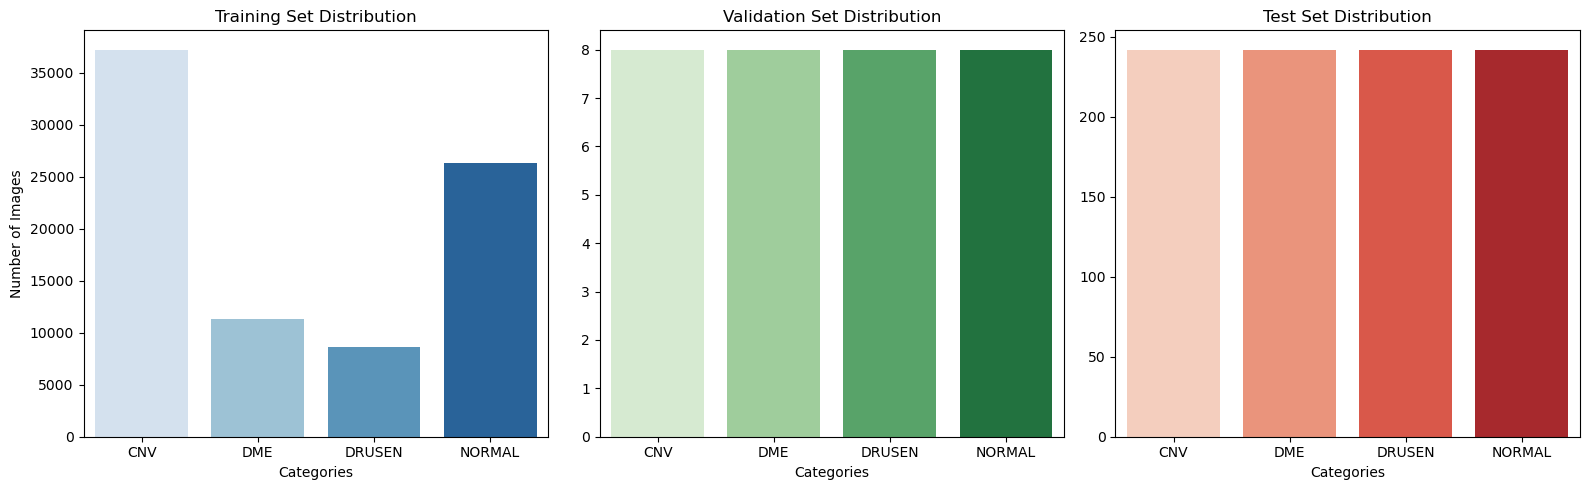

In [4]:
train_path = 'Dataset/OCT2017/train'
test_path  = 'Dataset/OCT2017/test'
val_path   = 'Dataset/OCT2017/val'

categories = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

def count_images_in_directory(directory):
    category_count = {}
    for category in categories:
        category_path = os.path.join(directory, category)
        category_count[category] = len(os.listdir(category_path))
    return category_count

train_distribution = count_images_in_directory(train_path)
test_distribution = count_images_in_directory(test_path)
val_distribution = count_images_in_directory(val_path)

def plot_class_distribution():
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 3, 1)
    sns.barplot(x=list(train_distribution.keys()), y=list(train_distribution.values()), palette='Blues')
    plt.title('Training Set Distribution')
    plt.xlabel('Categories')
    plt.ylabel('Number of Images')
    plt.subplot(1, 3, 2)
    sns.barplot(x=list(val_distribution.keys()), y=list(val_distribution.values()), palette='Greens')
    plt.title('Validation Set Distribution')
    plt.xlabel('Categories')
    plt.subplot(1, 3, 3)
    sns.barplot(x=list(test_distribution.keys()), y=list(test_distribution.values()), palette='Reds')
    plt.title('Test Set Distribution')
    plt.xlabel('Categories')
    plt.tight_layout()
    plt.show()

plot_class_distribution()


In [5]:
img_size = (128, 128)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=10, 
                                   width_shift_range=0.2, height_shift_range=0.2, 
                                   zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_path, target_size=img_size, batch_size=batch_size, class_mode='categorical')
val_generator = val_datagen.flow_from_directory(val_path, target_size=img_size, batch_size=batch_size, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_path, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False)


Found 83484 images belonging to 4 classes.
Found 32 images belonging to 4 classes.
Found 968 images belonging to 4 classes.


In [7]:
from collections import Counter

idx_to_class = {v: k for k, v in train_generator.class_indices.items()}
orig_counts = Counter(train_generator.classes)

print("Original train counts:")
for i in sorted(orig_counts):
    print(f"{idx_to_class[i]}: {orig_counts[i]}")


Original train counts:
CNV: 37205
DME: 11348
DRUSEN: 8616
NORMAL: 26315


In [8]:
import pandas as pd
import numpy as np

# Create a dataframe of filepaths and labels from the existing generator
df_train = pd.DataFrame({
    "filename": train_generator.filepaths,
    "class": [idx_to_class[i] for i in train_generator.classes],
})

# Oversample each class up to the size of the largest class
target_n = df_train["class"].value_counts().max()
balanced_parts = []
rng = np.random.RandomState(42)

for cls, grp in df_train.groupby("class"):
    if len(grp) < target_n:
        extra = grp.sample(target_n - len(grp), replace=True, random_state=42)
        grp = pd.concat([grp, extra], ignore_index=True)
    balanced_parts.append(grp)

df_train_bal = pd.concat(balanced_parts, ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced per-class counts:")
print(df_train_bal["class"].value_counts().sort_index())


Balanced per-class counts:
class
CNV       37205
DME       37205
DRUSEN    37205
NORMAL    37205
Name: count, dtype: int64


In [9]:
# Reuse your existing train_datagen (with augmentation) and same img_size/batch_size
train_balanced_generator = train_datagen.flow_from_dataframe(
    df_train_bal,
    x_col="filename",
    y_col="class",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    validate_filenames=False,
)

# 👉 Later, use this in model.fit:
# history = model.fit(train_balanced_generator, validation_data=val_generator, epochs=..., ...)


Found 148820 non-validated image filenames belonging to 4 classes.


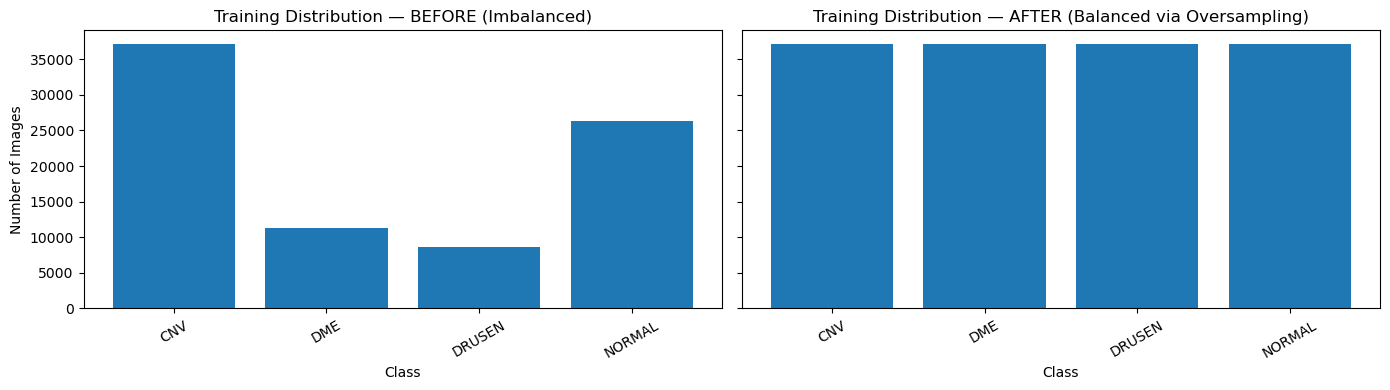

In [10]:
import matplotlib.pyplot as plt

# Build comparable count dicts (name -> count)
orig_name_counts = {idx_to_class[i]: orig_counts[i] for i in sorted(orig_counts)}
new_name_counts  = df_train_bal["class"].value_counts().to_dict()

# Shared, ordered class list
classes = sorted(orig_name_counts.keys())

fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

# BEFORE
axes[0].bar(classes, [orig_name_counts[c] for c in classes])
axes[0].set_title("Training Distribution — BEFORE (Imbalanced)")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Number of Images")
axes[0].tick_params(axis='x', rotation=30)

# AFTER
axes[1].bar(classes, [new_name_counts.get(c, 0) for c in classes])
axes[1].set_title("Training Distribution — AFTER (Balanced via Oversampling)")
axes[1].set_xlabel("Class")
axes[1].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()


Found 2 non-validated image filenames belonging to 1 classes.
Found 2 non-validated image filenames belonging to 1 classes.
Found 2 non-validated image filenames belonging to 1 classes.
Found 2 non-validated image filenames belonging to 1 classes.


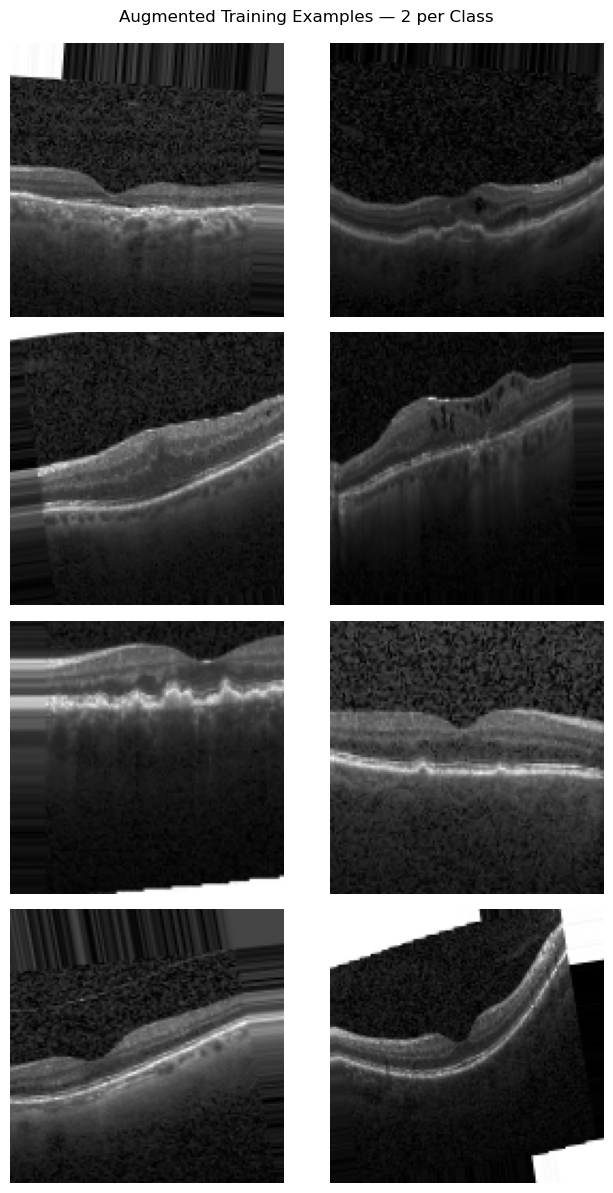

In [15]:
# ---- Augmented examples per class (2 per class) ----
import matplotlib.pyplot as plt

samples_per_class = 2  # "a couple"
rows, cols = len(classes), samples_per_class

fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.5, rows * 3.0))
if rows == 1:
    axes = [axes]  # ensure 2D indexing if only one class (unlikely here)

for r, cls in enumerate(classes):
    # pick a couple of filepaths for this class from the *balanced* dataframe
    df_cls = df_train_bal[df_train_bal["class"] == cls].sample(
        n=samples_per_class, replace=True, random_state=42
    )

    # use the SAME train_datagen to apply your augmentation + rescale
    # seed makes the augmentation reproducible for this preview
    gen = train_datagen.flow_from_dataframe(
        df_cls,
        x_col="filename",
        y_col="class",
        target_size=img_size,
        class_mode="categorical",
        batch_size=samples_per_class,
        shuffle=False,
        validate_filenames=False,
        seed=123 + r  # per-class seed so each row is stable
    )

    batch_x, batch_y = next(gen)  # augmented images

    for c in range(samples_per_class):
        ax = axes[r][c] if rows > 1 else axes[c]
        ax.imshow(batch_x[c])      # already in [0,1] due to rescale=1./255
        ax.axis("off")
        if c == 0:
            ax.set_ylabel(cls, rotation=0, labelpad=30, fontsize=10, va="center")

plt.suptitle("Augmented Training Examples — 2 per Class", y=0.99, fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers, models

num_classes = len(categories)  # keep your categories list

def build_small_cnn(input_shape=(128, 128, 3), l2=1e-4, dropout=0.3):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        # Block 1
        layers.Conv2D(32, 3, padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(),

        # Block 2
        layers.Conv2D(64, 3, padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(),

        # Block 3
        layers.Conv2D(128, 3, padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(l2)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(),

        # Head
        layers.GlobalAveragePooling2D(),
        layers.Dropout(dropout),
        layers.Dense(64, activation='relu',
                     kernel_regularizer=regularizers.l2(l2),
                     kernel_initializer='he_normal'),
        layers.Dropout(dropout),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = build_small_cnn()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,660 (401.02 KB)

 Trainable params: 102,212 (399.27 KB)

 Non-trainable params: 448 (1.75 KB)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=3,       # stop if no improvement for 3 epochs
    restore_best_weights=True
)

history = model.fit(
    train_balanced_generator,
    validation_data=val_generator,
    epochs=25,        # start here; early_stop may end earlier
    callbacks=[early_stop]
)


Epoch 1/25
  26/4651 ━━━━━━━━━━━━━━━━━━━━ 27:16 354ms/step - accuracy: 0.3285 - loss: 1.4384

KeyboardInterrupt: 

In [ ]:
def plot_learning_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.tight_layout(); plt.show()
plot_learning_curves(history)


In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 168ms/step - accuracy: 0.9638 - loss: 0.2004
Test Accuracy: 96.38%


In [ ]:
test_predictions = model.predict(test_generator)
test_predictions_labels = np.argmax(test_predictions, axis=1)
true_labels = test_generator.classes
class_report = classification_report(true_labels, test_predictions_labels, target_names=categories)
print('Classification Report:')
print(class_report)


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step
Classification Report:
              precision    recall  f1-score   support

         CNV       0.93      0.95      0.94       242
         DME       0.98      0.67      0.80       242
      DRUSEN       0.96      0.95      0.95       242
      NORMAL       0.76      1.00      0.87       242

    accuracy                           0.89       968
   macro avg       0.91      0.89      0.89       968
weighted avg       0.91      0.89      0.89       968


In [ ]:
conf_matrix = confusion_matrix(true_labels, test_predictions_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix'); plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.show()


[Figure output omitted in this reconstruction]

In [ ]:
from sklearn.preprocessing import label_binarize
def plot_multiclass_roc(test_labels, test_predictions):
    test_labels_binarized = label_binarize(test_labels, classes=[0,1,2,3])
    fpr,tpr,roc_auc = {},{},{}
    for i in range(len(categories)):
        from sklearn.metrics import roc_curve, auc
        fpr[i], tpr[i], _ = roc_curve(test_labels_binarized[:, i], test_predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    plt.figure(figsize=(10,8))
    for i, color in zip(range(len(categories)), ['blue','green','orange','red']):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {categories[i]} (area = {roc_auc[i]:0.2f})')
    plt.plot([0,1], [0,1], 'k--', lw=2)
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve'); plt.legend(loc='lower right'); plt.show()
plot_multiclass_roc(true_labels, test_predictions)


[Figure output omitted in this reconstruction]

In [ ]:
def plot_sample_predictions(test_generator, num_samples=10):
    test_generator.reset()
    sample_images, sample_labels = next(test_generator)
    predictions = model.predict(sample_images)
    predicted_labels = np.argmax(predictions, axis=1)
    plt.figure(figsize=(15,15))
    for i in range(num_samples):
        plt.subplot(5,2,i+1)
        plt.imshow(sample_images[i])
        plt.title(f'Actual: {categories[np.argmax(sample_labels[i])]}, Predicted: {categories[predicted_labels[i]]}')
        plt.axis('off')
    plt.show()
plot_sample_predictions(test_generator)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


[Figure output omitted in this reconstruction]

In [ ]:
import os
os.makedirs('saved_models', exist_ok=True)
model.save('saved_models/my_model.keras')


**Note:** Plots are referenced but image data from the PDF export isn't embedded here. To regenerate figures, run the corresponding cells in an environment with the dataset available.